In [1]:
pip install librosa pydub torchaudio transformers


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import librosa
import numpy as np
import torchaudio
import random
from pydub import AudioSegment
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Model
import torch

C:\Users\ACER\anacond3\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:
def load_and_preprocess_audio(file_path, target_sr=16000):
    # Load audio with Librosa, resampling to target_sr
    audio, sr = librosa.load(file_path, sr=target_sr)
    
    # Trim leading and trailing silence
    audio, _ = librosa.effects.trim(audio)
    
    # Perform noise reduction (simple method by subtracting mean)
    audio = audio - np.mean(audio)
    
    return audio, sr


In [4]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-large-xlsr-53")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-large-xlsr-53")

In [5]:
def extract_wav2vec_large_features(audio, target_sr=16000, duration=3):
    # Resample to target sample rate
    audio = librosa.resample(audio, orig_sr=librosa.get_samplerate(audio), target_sr=target_sr)
    # Pad or truncate to the target duration
    audio = librosa.util.fix_length(audio, int(duration * target_sr))

    # Process the audio with Wav2Vec feature extractor
    inputs = feature_extractor(audio, sampling_rate=target_sr, return_tensors="pt", padding=True)
    
    # Extract embeddings
    with torch.no_grad():
        features = model(**inputs).last_hidden_state.mean(dim=1).squeeze().numpy()
    
    return features


In [6]:
def extract_wav2vec_large_features(audio, target_sr=16000, duration=1.0):
    # Convert audio to the correct sampling rate
    if audio.ndim > 1:
        audio = audio.mean(axis=1)  # Convert to mono if stereo
    
    # Check if audio length is sufficient
    required_length = int(target_sr * duration)
    if len(audio) < required_length:
        # Pad with zeros
        padding = np.zeros(required_length - len(audio))
        audio = np.concatenate((audio, padding))
    
    # Process the audio with Wav2Vec
    inputs = feature_extractor(audio, sampling_rate=target_sr, return_tensors="pt", padding=True)
    
    with torch.no_grad():
        features = model(**inputs).last_hidden_state.mean(dim=1)
    
    return features.squeeze().numpy()


In [7]:
import librosa

def extract_mfcc(file_path, sr=16000, n_mfcc=13):
    audio, _ = librosa.load(file_path, sr=sr)
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    return mfccs.mean(axis=1)  # Averaging MFCCs over time


In [8]:
def extract_mel_spectrogram(file_path, target_shape=(128, 63)):
    y, sr = librosa.load(file_path, sr=16000)  # Adjust the sampling rate if necessary
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    
    # Convert to log scale (dB) for better visualization and model input
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    # If the Mel spectrogram width is less than target, pad it; if more, trim it
    if mel_spec_db.shape[1] < target_shape[1]:
        mel_spec_db = np.pad(mel_spec_db, ((0, 0), (0, target_shape[1] - mel_spec_db.shape[1])), mode='constant')
    else:
        mel_spec_db = mel_spec_db[:, :target_shape[1]]
    
    return mel_spec_db

In [9]:
def augment_audio(audio, sr, pitch_shift_steps=2, time_stretch_rate=1.2):
    # Pitch shifting
    augmented_audio = librosa.effects.pitch_shift(y=audio, sr=sr, n_steps=pitch_shift_steps)
    
    # Time stretching
    augmented_audio = librosa.effects.time_stretch(augmented_audio, rate=time_stretch_rate)
    
    return augmented_audio


In [10]:
def preprocess_and_extract_features(file_path, augment=False):
    # Load audio
    audio, sr = librosa.load(file_path, sr=16000)
    
    # Optionally augment audio
    if augment:
        audio = augment_audio(audio, sr)  # Ensure this function is defined

    # Extract features
    mfcc_features = extract_mfcc(file_path)
    mel_spectrogram_features = extract_mel_spectrogram(file_path)
    wav2vec_features = extract_wav2vec_large_features(audio)  # Updated to include padding

    return mfcc_features, mel_spectrogram_features, wav2vec_features


In [11]:
file_path = r'C:\Users\ACER\Desktop\AudioDF\Merged_Dataset\real\12613.wav'
wav2vec_features, mfcc_features, mel_spectrogram_features = preprocess_and_extract_features(file_path)
print("Wav2Vec Features shape:", wav2vec_features.shape)
print("MFCC Features shape:", mfcc_features.shape)
print("Mel-Spectrogram shape:", mel_spectrogram_features.shape)

Wav2Vec Features shape: (13,)
MFCC Features shape: (128, 63)
Mel-Spectrogram shape: (1024,)


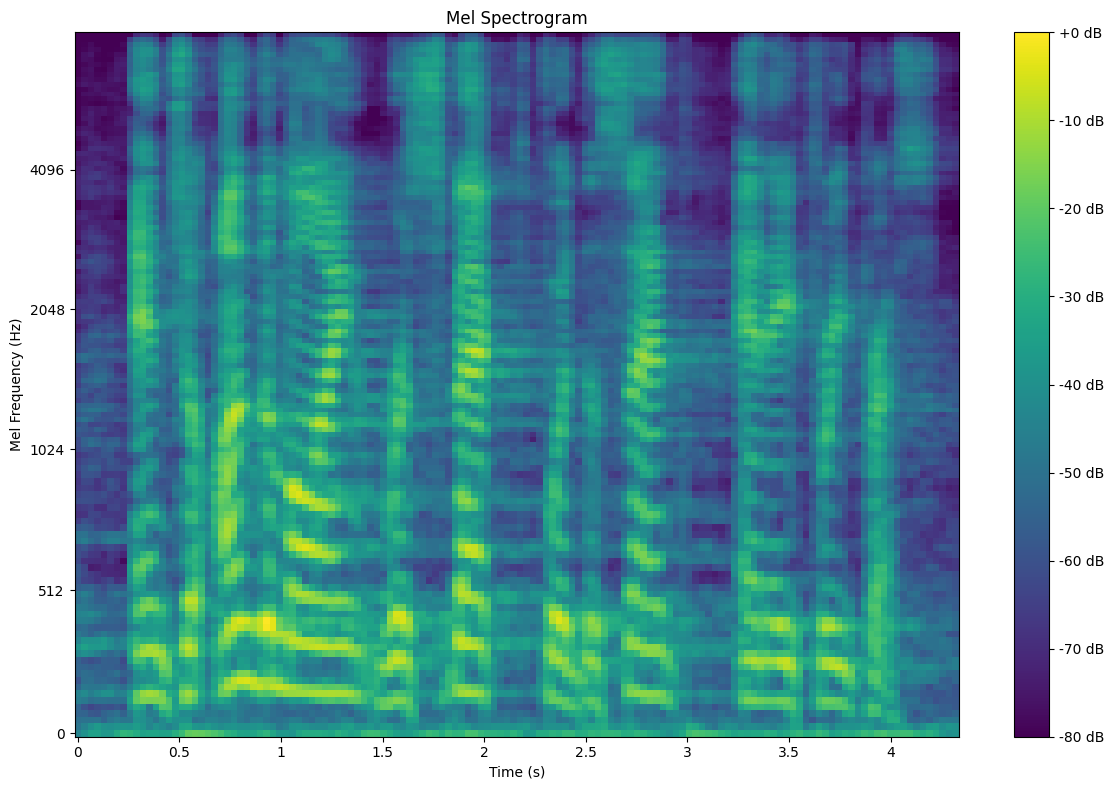

In [12]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def plot_mel_spectrogram(file_path, sr=16000, n_mels=128):
    # Load the audio file
    audio, _ = librosa.load(file_path, sr=sr)
    
    # Compute the Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    
    # Convert to decibels
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    # Plotting
    plt.figure(figsize=(12, 8))
    librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Mel Frequency (Hz)')
    plt.tight_layout()
    plt.show()

# Usage
file_path = r'C:\Users\ACER\Desktop\AudioDF\Merged_Dataset\real\12613.wav'
plot_mel_spectrogram(file_path)


In [13]:
import os
import numpy as np

def preprocess_and_extract_features(file_path, augment=False):
    # Load audio
    audio, sr = librosa.load(file_path, sr=16000)
    
    # Optionally augment audio
    if augment:
        audio = augment_audio(audio, sr)  # Ensure this function is defined

    # Extract features
    mfcc_features = extract_mfcc(file_path)
    mel_spectrogram_features = extract_mel_spectrogram(file_path)
    wav2vec_features = extract_wav2vec_large_features(audio)  # Updated to include padding

    return mfcc_features, mel_spectrogram_features, wav2vec_features

    
def extract_features_from_dataset(dataset_path, augment=False):
    mfcc_features_list = []
    mel_spectrogram_features_list = []
    wav2vec_features_list = []
    labels_list = []

    for label in ['real', 'fake']:
        folder_path = os.path.join(dataset_path, label)
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            mfcc, mel_spectrogram, wav2vec = preprocess_and_extract_features(file_path, augment=augment)
            mfcc_features_list.append(mfcc)
            mel_spectrogram_features_list.append(mel_spectrogram)
            wav2vec_features_list.append(wav2vec)
            labels_list.append(0 if label == 'real' else 1)

    return (np.array(mfcc_features_list), 
            np.array(mel_spectrogram_features_list), 
            np.array(wav2vec_features_list), 
            np.array(labels_list))

# Usage
dataset_path = r'C:\Users\ACER\Desktop\AudioDF\Merged_Dataset' # Adjust path accordingly
mfcc_features, mel_spectrogram_features, wav2vec_features, labels = extract_features_from_dataset(dataset_path, augment=True)
print("MFCC Features shape:", mfcc_features.shape)
print("Mel Spectrogram Features shape:", mel_spectrogram_features.shape)
print("Wav2Vec Features shape:", wav2vec_features.shape)
print("Labels shape:", labels.shape)


C:\Users\ACER\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1600
  warnings.warn(
C:\Users\ACER\AppData\Roaming\Python\Python312\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1920
  warnings.warn(


MFCC Features shape: (4000, 13)
Mel Spectrogram Features shape: (4000, 128, 63)
Wav2Vec Features shape: (4000, 1024)
Labels shape: (4000,)


In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Dropout, Reshape, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

# Define model architecture with L2 regularization and tuned dropout
def build_regularized_model():
    # MFCC input branch
    mfcc_input = Input(shape=(13,))
    mfcc_dense = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(mfcc_input)
    mfcc_dense = Dropout(0.4)(mfcc_dense)  # Increased dropout rate

    # Mel spectrogram input branch
    mel_input = Input(shape=(128, 63, 1))
    mel_conv1 = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(mel_input)
    mel_pool1 = MaxPooling2D((2, 2))(mel_conv1)
    mel_conv2 = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001))(mel_pool1)
    mel_pool2 = MaxPooling2D((2, 2))(mel_conv2)
    mel_flatten = Flatten()(mel_pool2)

    # Wav2Vec embeddings input branch
    wav2vec_input = Input(shape=(1024,))
    wav2vec_dense = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(wav2vec_input)
    wav2vec_dense = Dropout(0.4)(wav2vec_dense)  # Increased dropout rate

    # Concatenate branches
    concatenated = tf.keras.layers.Concatenate()([mfcc_dense, mel_flatten, wav2vec_dense])
    dense1 = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(concatenated)
    dense1 = Dropout(0.5)(dense1)  # Increased dropout rate in final layers
    output = Dense(1, activation='sigmoid')(dense1)

    model = Model(inputs=[mfcc_input, mel_input, wav2vec_input], outputs=output)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Build and summarize the model
model = build_regularized_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 63,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 61,   │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 30,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 28,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 1024)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │        896 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 14,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │    131,200 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 26880)     │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 27072)     │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ flatten[0][0],    │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  3,465,344 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        129 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,616,385 (13.80 MB)

 Trainable params: 3,616,385 (13.80 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
import numpy as np

def combine_features(mfccs, mel_spectrograms, wav2vec_embeddings):
    # Flatten the Mel spectrograms
    mel_spectrograms_flattened = mel_spectrograms.reshape((mel_spectrograms.shape[0], -1))
    
    # Ensure MFCCs and Wav2Vec embeddings are also in 2D if necessary
    if mfccs.ndim > 2:
        mfccs = mfccs.reshape((mfccs.shape[0], -1))
    if wav2vec_embeddings.ndim > 2:
        wav2vec_embeddings = wav2vec_embeddings.reshape((wav2vec_embeddings.shape[0], -1))

    # Combine features into a single array
    combined_features = np.concatenate((mfccs, mel_spectrograms_flattened, wav2vec_embeddings), axis=1)
    
    return combined_features

# Example usage
combined_features = combine_features(mfcc_features, mel_spectrogram_features, wav2vec_features)
print("Combined Features Shape:", combined_features.shape)


Combined Features Shape: (4000, 9101)


In [16]:
print("Original shape of mel_spectrogram_features:", mel_spectrogram_features.shape)


Original shape of mel_spectrogram_features: (4000, 128, 63)


In [17]:

from sklearn.model_selection import train_test_split
# Reshape Mel spectrograms to add a channel dimension
mel_spectrogram_features = mel_spectrogram_features.reshape((-1, 128, 63, 1))  # Add channel dimension

# Split the data into training and testing sets
X_mfcc_train, X_mfcc_test, X_mel_train, X_mel_test, X_wav2vec_train, X_wav2vec_test, y_train, y_test = train_test_split(
    mfcc_features, mel_spectrogram_features, wav2vec_features, labels, test_size=0.2, random_state=42
)

# Print the shapes of the resulting datasets
print("Training set shapes:")
print("X_mfcc:", X_mfcc_train.shape)
print("X_mel:", X_mel_train.shape)
print("X_wav2vec:", X_wav2vec_train.shape)
print("y:", y_train.shape)

print("\nTesting set shapes:")
print("X_mfcc:", X_mfcc_test.shape)
print("X_mel:", X_mel_test.shape)
print("X_wav2vec:", X_wav2vec_test.shape)
print("y:", y_test.shape)


Training set shapes:
X_mfcc: (3200, 13)
X_mel: (3200, 128, 63, 1)
X_wav2vec: (3200, 1024)
y: (3200,)

Testing set shapes:
X_mfcc: (800, 13)
X_mel: (800, 128, 63, 1)
X_wav2vec: (800, 1024)
y: (800,)


In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

#Split data into training and validation sets
X_mfcc_train, X_mfcc_val, X_mel_train, X_mel_val, X_wav2vec_train, X_wav2vec_val, y_train, y_val = train_test_split(
    mfcc_features, mel_spectrogram_features, wav2vec_features, labels, test_size=0.2, random_state=42
)

# Define callbacks to improve training
checkpoint = ModelCheckpoint(
    'best_model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1
)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# Training the model
history = model.fit(
    [X_mfcc_train, X_mel_train, X_wav2vec_train],
    y_train,
    validation_data=([X_mfcc_val, X_mel_val, X_wav2vec_val], y_val),
    epochs=50,
    batch_size=8,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)


model.save('audio_deepfake_finetune_model3.h5')
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate([X_mfcc_val, X_mel_val, X_wav2vec_val], y_val)
print(f'Validation Accuracy: {val_accuracy:.4f}')
print(f'Validation Loss: {val_loss:.4f}')


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.9528 - loss: 0.1873
Epoch 1: val_accuracy improved from -inf to 0.90625, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 364ms/step - accuracy: 0.9528 - loss: 0.1875 - val_accuracy: 0.9062 - val_loss: 0.3147 - learning_rate: 0.0010
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9605 - loss: 0.1698
Epoch 2: val_accuracy improved from 0.90625 to 0.91500, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 462ms/step - accuracy: 0.9604 - loss: 0.1700 - val_accuracy: 0.9150 - val_loss: 0.2773 - learning_rate: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9674 - loss: 0.1568
Epoch 3: val_accuracy did not improve from 0.91500
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 412ms/step - accuracy: 0.9674 - loss: 0.1567 - val_accuracy: 0.9150 - val_loss: 0.3367 - learning_rate: 0.0010
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9695 - loss: 0.1488
Epoc

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.9233 - loss: 0.2623
Validation Accuracy: 0.9150
Validation Loss: 0.2773


In [35]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
# Load without compilation
model = load_model('audio_deepfake_finetune_model3.h5', compile=False)

# Compile manually (optional, but necessary if you'll continue training the model)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate on test set
test_loss, test_accuracy = model.evaluate([X_mfcc_test, X_mel_test, X_wav2vec_test], y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Make predictions
y_pred = (model.predict([X_mfcc_test, X_mel_test, X_wav2vec_test]) > 0.5).astype("int32")

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

# Optional: Display confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.9233 - loss: 0.2623
Test Accuracy: 0.9150
Test Loss: 0.2773
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Classification Report:
              precision    recall  f1-score   support

        Real       0.91      0.93      0.92       422
        Fake       0.92      0.90      0.91       378

    accuracy                           0.92       800
   macro avg       0.92      0.91      0.91       800
weighted avg       0.92      0.92      0.91       800

Confusion Matrix:
[[391  31]
 [ 37 341]]
